# Bias on Wikipedia

This ipython notebook is created for DATA512 at UW for this assignment: https://wiki.communitydata.cc/HCDS_(Fall_2017)/Assignments#A2:_Bias_in_data

Our goal is to analyze the content of wikipedia to understand the biases of the site by looking at the content coverage for political members of countries. We look at how many pages there are (as a percent of the country's population) and how many of the pages are high quality (using scores from the ORES system, more info below).

In the end, we show the top/bottom 10 countries for these 2 categories.

## Related Data Files

raw data files:
- page_data.csv : raw wikipedia data
- WPDS_2018_data.csv : raw country population data

Output files:
- ores_data.csv : articles scores from the ORES system
- combined_data.csv : combined data (country population, ores data and wikipedia data)


First, import necessary packages

In [1]:
import requests
import json
import pandas as pd
import numpy as np



Import the data, and print out the first few rows to see examples.

Data comes from a few different sources. Wikipedia data is available via figshare (https://figshare.com/articles/Untitled_Item/5513449 , under country/data/) with license CC-BY-SA 4.0. This contains "most English-language Wikipedia articles within the category 'Category:Politicians by nationality' and subcategories". This data contains 3 columns, which are called out in the above link as follows:

1. "country", containing the sanitised country name, extracted from the category name;
2. "page", containing the unsanitised page title.
3. "last_edit", containing the edit ID of the last edit to the page.

Population data is available via https://www.dropbox.com/s/5u7sy1xt7g0oi2c/WPDS_2018_data.csv?dl=0.
This file contains the population in millions from mid-2018 along with the country name.

A copy of the datasets, downloaded in oct, 2018, are available in this repo.

In [2]:
wiki_data = pd.read_csv('page_data.csv')
country_data = pd.read_csv('WPDS_2018_data.csv',thousands=',')
country_data.rename(columns={"Population mid-2018 (millions)": "population"},inplace=True)

wiki_data.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [3]:
country_data.head()

,Geography,population
0,AFRICA,1284.0
1,Algeria,42.7
2,Egypt,97.0
3,Libya,6.5
4,Morocco,35.2


Here we create a helper function for getting ores scores

This function takes revision ids (and the headers needed to make the call) and scores the function using the ORES system. The score and the revision id are appended to the ores_data list.

ORES (Objective Revision Evaluation Service) is a machine learning service that ranks the quality of a given article. The ranks go from best to worst as FA, GA, B, C, Start and Stub. For the purposes of this analysis, we use only the predicted category (rather than the probabilities, which are also available).
link with more info: https://www.mediawiki.org/wiki/ORES



In [4]:

def get_ores_data(revision_ids, headers):
    temp_data = []
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = pd.read_json(json.dumps(api_call.json(), indent=4, sort_keys=True))
    for id in response['enwiki']['scores']:
        try:
            ores_data.append([id, response['enwiki']['scores'][id]['wp10']['score']['prediction']])
        except:
            pass
    
    #print(json.dumps(response, indent=4, sort_keys=True))
    #return temp_data #response

Here we define the header needed to call the above function and iterate over all of the revions, calling the function in batches (of about 100, or 472 batches for slightly less than 47k revisions).

In [5]:
%%time
# So if we grab some example revision IDs and turn them into a list and then call get_ores_data...
ores_data = [] #pd.DataFrame(columns =['revid','category'])
#ores_data.append([['a','b']])
#print(ores_data)
headers = {'User-Agent' : 'https://github.com/your_github_username', 'From' : 'your_uw_email@uw.edu'}
for i in np.array_split(np.asarray(wiki_data['rev_id']),472): #, 472): #split into buckets of approximately 100
    get_ores_data(i, headers)#,columns =['revid','category']
    #temp_data = pd.DataFrame(get_ores_data(i, headers),columns =['revid','category'])
    
    #print("here")
    #print(ores_data)
    #print(temp_data)
    #ores_data.append(temp_data)

CPU times: user 14.1 s, sys: 664 ms, total: 14.7 s
Wall time: 2min 24s


Here we convert the ores_data into a pandas dataframe and save to a csv for reference.

In [6]:
ores_data = pd.DataFrame(ores_data,columns =['revision_id','article_quality'])#.set_index('revision_id')
ores_data.to_csv('ores_data.csv')

We convert revision_id to a int so we can join it to the wikipedia data.

In [7]:
#check out ores
ores_data['revision_id'] = ores_data['revision_id'].astype(int)
#ores_data.set_index('revid')
#ores_data.reset_index(inplace=True)
ores_data.head()


,revision_id,article_quality
0,355319463,Stub
1,391862046,Stub
2,391862070,Stub
3,391862409,Stub
4,391862819,Stub


Here we merge the wikipedia data to the ores data on the revision id. We also merge onto the country data on the country/geography columns. There are 44,973 rows left after we inner join.

In [8]:
# Merge data
combined_data = wiki_data.merge(country_data,
                                how = 'inner',
                                left_on ='country',
                                right_on = 'Geography').merge(ores_data,
                                                              how = 'inner',
                                                              left_on = 'rev_id',
                                                              right_on = 'revision_id'
                                                             )
print(combined_data.shape)


(44973, 7)


Here is a preview of the US data:

In [9]:
combined_data[combined_data['country']=='United States'].head()

,page,country,rev_id,Geography,population,revision_id,article_quality
26912,Butler-Belmont family,United States,470173494,United States,328.0,470173494,Start
26913,Heard-Hawes family,United States,502721672,United States,328.0,502721672,C
26914,Russell family (American political family),United States,550953646,United States,328.0,550953646,Stub
26915,Read family of Delaware,United States,651856758,United States,328.0,651856758,Start
26916,Template:US-politician-stub,United States,666834672,United States,328.0,666834672,Stub


We filter the new dataset to remove duplicate columns and save this to a csv.

In [10]:
combined_data = combined_data[['country','page','revision_id','article_quality','population']]
combined_data.to_csv('combined_data.csv')

## Analysis

Here we start analysing the data. First, we create a pivot table with population by country.

In [11]:
# Analysis
articles_and_population = combined_data.pivot_table(values = ['population'],
                          index = ['country'],
                          dropna = False,
                          #columns = ['article_quality'],
                          aggfunc = {'population': min,'country':'count'}
                         ).rename(columns={"country": "num_articles"}).reset_index()
articles_and_population.shape

(180, 3)

Next, we create a pivot table with number of high quality articles by country.

In [12]:
high_qual_articles = combined_data[combined_data['article_quality'].isin(['FA','GA'])].pivot_table(values = ['population'],
                          index = ['country'],
                          dropna = False,
                          #columns = ['article_quality'],
                          aggfunc = {'country':'count'}
                         ).rename(columns={"country": "num_high_quality_articles"}).reset_index()
high_qual_articles.shape

(143, 2)

We join the datasets and fill NAs with zeros. We change num_articles to be an int and population to be a float.

We then calculate the articles_per_population (which is per million people) and the high quality article percentage for each country.

Finally, we set the index as the country (as these are unique) and display the results.

In [13]:
dataset = articles_and_population.merge(high_qual_articles, how='left').fillna(0)
dataset['num_articles'] = dataset['num_articles'].astype(int)
dataset['population'] = dataset['population'].astype(float)



#dataset.dropna(inplace=True)
dataset['articles_per_population'] = dataset['num_articles'] / dataset['population']
dataset['high_qual_article_perc'] = dataset['num_high_quality_articles'] / dataset['num_articles']
dataset.set_index('country',inplace=True)
dataset

,num_articles,population,num_high_quality_articles,articles_per_population,high_qual_article_perc
country,,,,,
Afghanistan,326,36.50,10.0,8.931507,0.030675
Albania,460,2.90,4.0,158.620690,0.008696
Algeria,119,42.70,2.0,2.786885,0.016807
Andorra,34,0.08,0.0,425.000000,0.000000
Angola,110,30.40,0.0,3.618421,0.000000
Antigua and Barbuda,25,0.10,0.0,250.000000,0.000000
Argentina,496,44.50,15.0,11.146067,0.030242
Armenia,198,3.00,5.0,66.000000,0.025253
Australia,1566,24.10,42.0,64.979253,0.026820


Finally, display the top and bottome countries by articles per million people. Tuvalu has the highest value, but does have an extremely small population. Of the represented countries, India has the smallest article per million people.

In [14]:
dataset.sort_values(by = 'articles_per_population',ascending = False)[0:10]


,num_articles,population,num_high_quality_articles,articles_per_population,high_qual_article_perc
country,,,,,
Tuvalu,55,0.01,5.0,5500.000000,0.090909
Nauru,53,0.01,0.0,5300.000000,0.000000
San Marino,82,0.03,0.0,2733.333333,0.000000
Monaco,40,0.04,0.0,1000.000000,0.000000
Liechtenstein,29,0.04,0.0,725.000000,0.000000
Tonga,63,0.10,1.0,630.000000,0.015873
Marshall Islands,37,0.06,0.0,616.666667,0.000000
Iceland,206,0.40,2.0,515.000000,0.009709
Andorra,34,0.08,0.0,425.000000,0.000000


In [15]:
dataset.sort_values(by = 'articles_per_population',ascending = True)[0:10]

,num_articles,population,num_high_quality_articles,articles_per_population,high_qual_article_perc
country,,,,,
India,986,1371.3,14.0,0.719026,0.014199
Indonesia,214,265.2,8.0,0.806938,0.037383
China,1135,1393.8,33.0,0.814321,0.029075
Uzbekistan,29,32.9,1.0,0.881459,0.034483
Ethiopia,105,107.5,1.0,0.976744,0.009524
Zambia,25,17.7,0.0,1.412429,0.000000
"Korea, North",39,25.6,7.0,1.523438,0.179487
Thailand,112,66.2,3.0,1.691843,0.026786
Bangladesh,323,166.4,3.0,1.941106,0.009288


And lastly, we look at the top and bottom countries by high quality article percentage. North Korea has the highest percentage at approximately 18% while Tanzania has the lowest at around .2%. Note that there are some countries that have been removed due to not having any high quality articles. The full list of these countries is at the end.

In [16]:
dataset.sort_values(by = 'high_qual_article_perc',ascending = False)[0:10]


,num_articles,population,num_high_quality_articles,articles_per_population,high_qual_article_perc
country,,,,,
"Korea, North",39,25.60,7.0,1.523438,0.179487
Saudi Arabia,119,33.40,16.0,3.562874,0.134454
Central African Republic,68,4.70,8.0,14.468085,0.117647
Romania,348,19.50,40.0,17.846154,0.114943
Mauritania,52,4.50,5.0,11.555556,0.096154
Bhutan,33,0.80,3.0,41.250000,0.090909
Tuvalu,55,0.01,5.0,5500.000000,0.090909
Dominica,12,0.07,1.0,171.428571,0.083333
United States,1092,328.00,82.0,3.329268,0.075092


In [17]:
#dataset.sort_values(by = 'high_qual_article_perc',ascending = True)[0:10]
dataset[dataset['high_qual_article_perc']>0].sort_values(by = 'high_qual_article_perc',ascending = True)[0:10]

,num_articles,population,num_high_quality_articles,articles_per_population,high_qual_article_perc
country,,,,,
Tanzania,408,59.1,1.0,6.903553,0.002451
Peru,354,32.2,1.0,10.993789,0.002825
Lithuania,248,2.8,1.0,88.571429,0.004032
Nigeria,682,195.9,3.0,3.481368,0.004399
Morocco,208,35.2,1.0,5.909091,0.004808
Fiji,199,0.9,1.0,221.111111,0.005025
Bolivia,187,11.3,1.0,16.548673,0.005348
Brazil,551,209.4,3.0,2.631328,0.005445
Luxembourg,180,0.6,1.0,300.000000,0.005556


Countries with 0 high quality articles:

In [25]:
dataset[dataset['high_qual_article_perc']==0].index

Index(['Andorra', 'Angola', 'Antigua and Barbuda', 'Bahamas', 'Barbados',
       'Belgium', 'Belize', 'Cameroon', 'Cape Verde', 'Comoros', 'Costa Rica',
       'Djibouti', 'Federated States of Micronesia', 'Finland', 'Guyana',
       'Kazakhstan', 'Kiribati', 'Lesotho', 'Liechtenstein', 'Macedonia',
       'Malta', 'Marshall Islands', 'Moldova', 'Monaco', 'Mozambique', 'Nauru',
       'Nepal', 'San Marino', 'Sao Tome and Principe', 'Seychelles',
       'Slovakia', 'Solomon Islands', 'Switzerland', 'Tunisia', 'Turkmenistan',
       'Uganda', 'Zambia'],
      dtype='object', name='country')

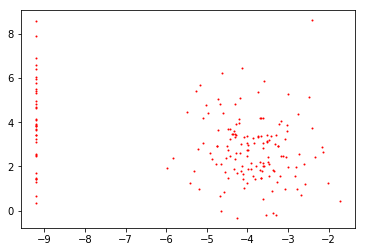

In [27]:
import matplotlib.pyplot as plt
plt.scatter(np.log(dataset['high_qual_article_perc']+.0001),
            np.log(dataset['articles_per_population']),
            c='r',
            s=1
           )
plt.show()

# Learnings 

From this analysis, we expected to see varying amounts of both coverage and quality articles as we look at different countries. While I expected there to be better coverage and quality for more developed nations, this did not appear to be the case. It is true that are discrepancies between nations, in large part due to the extreme differences in population between countries. There are many country-specific factors we have not included in this analysis that may help illustrate the trend including education, access to internet, wikipedia popularity, government internet regulations and more.